### 실습3 ###

영상 기하학 실습을 해봅시다.

**1. Find Homography**

1. 이미지 두 장을 찍어서(평면이면 좋습니다), 이 전에 한 실습처럼 ORB 피처매칭을 하고, 시각화해보세요.

   * note - Homography, Essential Matrix 둘 모두 undistort를 먼저 해야합니다. 일단 현대 핸드폰 카메라의 성능을 믿고 갑시다.

2. https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html 를 참고하여,
   
    Homography를 visualize하지 말고, 1번에서 한 visualize를 해보세요. 

    이 부분에서, matchesMask는 inlier mask를 의미합니다.
    ```python
    matchesMask = mask.ravel().tolist()
    ```

    cv2.drawMatches에 파라미터로 가져다주면 inlier만 그릴겁니다.

3. H를 제대로 정의했다면, 아래 정의시킨 함수'makePanoramaImage'로 파노라마 이미지가 생성됩니다.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# note H -> src image coordinates to dst_image coordinates
#   cv2.findHomography(src_points, dst_points...
#   를 써서 나온 homography를 H에 제공하면 됩니다.

def makePanoramaImage(src_image, dst_image, H):
    # calculate corners location
    src_h, src_w = src_image.shape[:2]
    dst_h, dst_w = dst_image.shape[:2]
    src_corners = np.float32([[0, 0], [0, src_h], [src_w, src_h], [src_w, 0]]).reshape(-1, 1, 2) # to make 4 1 2 tensor
    
    src_corners_warped = cv2.perspectiveTransform(src_corners, H)
    dst_corners = np.float32([[0, 0], [0, dst_h], [dst_w, dst_h], [dst_w, 0]]).reshape(-1, 1, 2)

    # combine, and calc image size
    all_corners = np.concatenate((src_corners_warped, dst_corners), axis=0)
    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    # warp src image
    translation_dist = [-x_min, -y_min]
    translation_matrix = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
    output_size = (x_max - x_min, y_max - y_min)

    # warp src to make panorama image
    panorama_image = cv2.warpPerspective(src_image, translation_matrix @ H, output_size)

    # copy dst image to panorama image
    panorama_image[translation_dist[1]:translation_dist[1] + dst_h, translation_dist[0]:translation_dist[0] + dst_w] = dst_image

    return panorama_image

In [ ]:
def show_panorama(src_image, dst_image, panorama_image):
    # 전체 출력 레이아웃 설정 (2행 1열)
    plt.figure(figsize=(30, 20))

    # 첫 번째 원본 이미지
    plt.subplot(2, 2, 1)
    plt.title("Source Image", fontsize=20)
    plt.imshow(cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # 두 번째 원본 이미지
    plt.subplot(2, 2, 2)
    plt.title("Destination Image", fontsize=20)
    plt.imshow(cv2.cvtColor(dst_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # 파노라마 이미지 (두 번째 행에 병합 결과)
    plt.subplot(2, 1, 2)
    plt.title("Panorama Image", fontsize=20)
    plt.imshow(cv2.cvtColor(panorama_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()


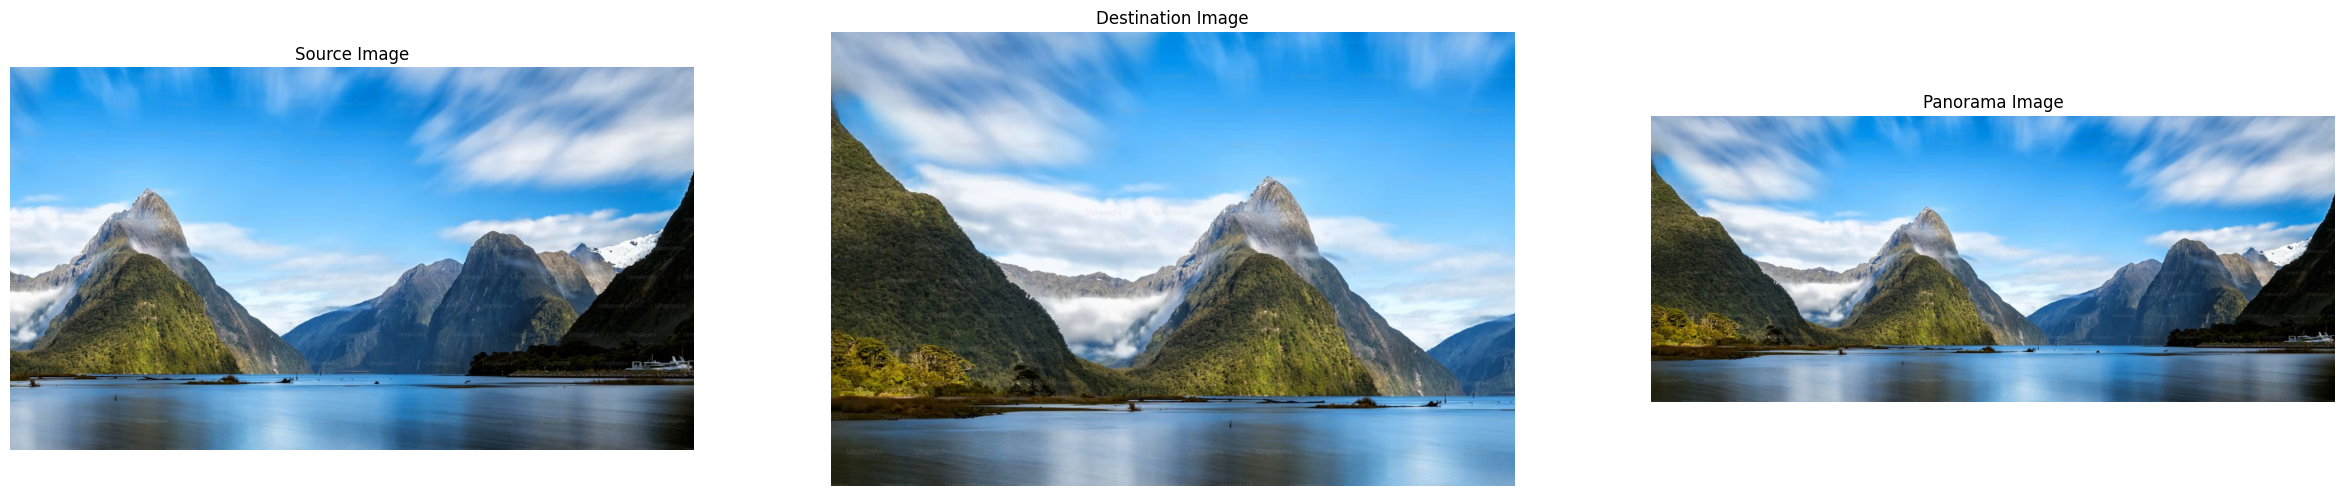

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 로드
src_image = cv2.imread('1.jpg')
dst_image = cv2.imread('2.jpg')

# 특징점 추출
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(src_image, None)
kp2, des2 = sift.detectAndCompute(dst_image, None)

# 특징점 매칭
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# 좋은 매칭점 선택 (ratio test)
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# 매칭된 좌표 추출
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# 호모그래피 계산
H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# 파노라마 이미지 생성
panorama_image = makePanoramaImage(src_image, dst_image, H)

# 결과 출력 (원본 포함)
show_panorama(src_image, dst_image, panorama_image)
